In [1]:
from pathlib import Path
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual

from db_queries import get_outputs, get_ids, get_age_metadata

from vivarium_inputs import get_raw_data, get_population_structure, get_demographic_dimensions
from vivarium_inputs.core import get_data
from vivarium_inputs.globals import Population
from vivarium_inputs.utilities import scrub_gbd_conventions
from gbd_mapping import causes, risk_factors

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend, LegendItem
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

In [3]:
# Important to note this is a baseline run, no interventions.

RESULTS_DIRECTORIES = {'India': Path("/share/costeffectiveness/results/vivarium_conic_sam_comparison/vivarium_conic_sam_comparison_baseline_India/2019_09_11_21_35_55"),
                       'Bangladesh': Path("/share/costeffectiveness/results/vivarium_conic_sam_comparison/vivarium_conic_sam_comparison_baseline_Bangladesh/2019_09_11_21_29_07"),
                       'Malawi': Path("/share/costeffectiveness/results/vivarium_conic_sam_comparison/vivarium_conic_sam_comparison_baseline_Malawi/2019_09_11_21_29_10"),
                       'Mali': Path("/share/costeffectiveness/results/vivarium_conic_sam_comparison/vivarium_conic_sam_comparison_baseline_Mali/2019_09_11_21_29_10"),
#                        'Pakistan': Path(""),
                       'Tanzania': Path("/share/costeffectiveness/results/vivarium_conic_sam_comparison/vivarium_conic_sam_comparison_baseline_Tanzania/2019_09_11_21_29_16")
                      }
COUNTRIES = list(RESULTS_DIRECTORIES.keys())
CAUSES = [causes.diarrheal_diseases, causes.lower_respiratory_infections, 
          causes.measles, causes.protein_energy_malnutrition, 
          causes.neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,
          causes.neonatal_sepsis_and_other_neonatal_infections, 
          causes.hemolytic_disease_and_other_neonatal_jaundice]
MEASURES = ['Deaths', 'YLLs', 'YLDs', 'DALYs', 'CSMR']

# Getting data from GBD

### The GBD ID dance

In [4]:
## use get_ids to figure out the stuff I want
gbd_measure_ids = get_ids("measure")

gbd_metric_ids = get_ids("metric")

gbd_age_group_set_ids = get_ids("age_group_set")
gbd_2015_age_group_set = 1
gbd_age_group_metadata = get_age_metadata(age_group_set_id=gbd_2015_age_group_set, gbd_round_id=5)
gbd_age_group_ids = get_ids("age_group")
# gbd_age_group_ids = gbd_age_group_ids.loc[gbd_age_group_ids['age_group_id'].isin(gbd_age_group_metadata['age_group_id'])]

gbd_sex_ids = get_ids("sex")

gbd_location_ids = get_ids("location")

# ID Mappings
LOCATION_IDS = dict(zip(gbd_location_ids['location_name'], gbd_location_ids['location_id']))
FULL_AGE_ID_SET = dict(zip(gbd_age_group_ids['age_group_id'], gbd_age_group_ids['age_group_name']))
AGE_IDS = {FULL_AGE_ID_SET[age_id]: age_id for age_id in gbd_age_group_metadata['age_group_id'].unique()}
SEX_IDS = {
    'Male': 1,
    'Female': 2
}
MEASURE_IDS = {
    'Deaths': 1,
    'DALYs': 2,
    'YLDs': 3,
    'YLLs': 4,
    'CSMR': 15  # TODO: Why broken ?
}
METRIC_IDS = {
    'rate': 3
}

In [5]:
def get_gbd_data(location, cause, measure):
    df = get_outputs("cause", 
                    cause_id=cause.gbd_id, 
                    metric_id=[METRIC_IDS['rate']], 
                    measure_id=[MEASURE_IDS[measure]], 
                    year_id=[2017],
                    location_id=[LOCATION_IDS[location]],
                    age_group_id=list(AGE_IDS.values()),
                    sex_id=list(SEX_IDS.values()),
                    gbd_round_id=5)
    df = df.set_index(['location_name', 'age_group_name', 'cause_name', 'sex', 'measure_name'])
    df = df[['lower', 'val', 'upper']]
    df = df.reset_index()
    
    return df

# Getting data from sim results

### Sim runtimes in hours

India


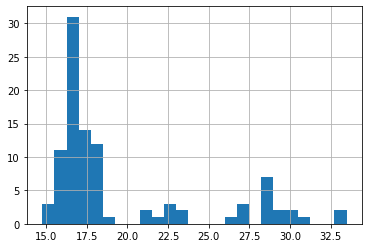

Bangladesh


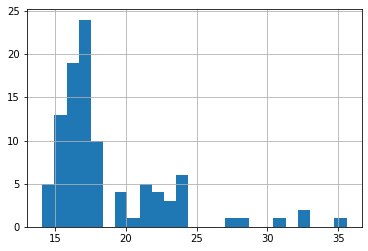

Malawi


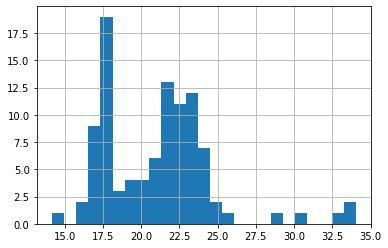

Mali


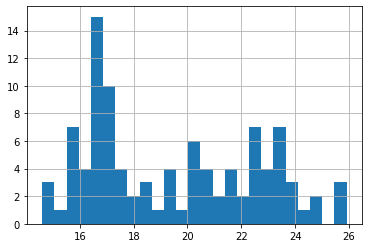

Tanzania


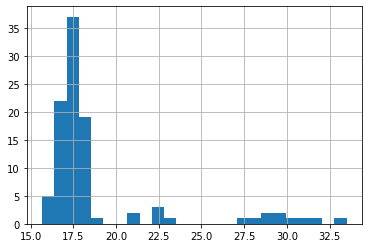

In [6]:
# TODO: Add titles etc, switch to Bokeh

for country, results_dir in RESULTS_DIRECTORIES.items():
    results = pd.read_hdf(results_dir / "output.hdf")
    print(country)
    (results['simulation_run_time'] / 3600.).hist(bins=25)
    plt.show()

### Real results

In [7]:
def make_result_frame(location, cause, measure):
    age_group_names = list(AGE_IDS.keys())
    age_group_names = [n.replace(" ", "_") for n in age_group_names]
    age_group_names = ["early_neonatal", "late_neonatal", "post_neonatal", "1_to_4" ]
    sex_group_names = ['male', 'female']
    index = pd.MultiIndex.from_product([[location], age_group_names, [cause.name], sex_group_names], 
                                       names=['location_name', 'age_group_name', 'cause_name', 'sex'])
    return pd.DataFrame({'lower': [np.nan], 'val': [np.nan], 'upper': [np.nan]}, index=index)


def get_result(data, location, cause, measure, measure_columns):
    result = make_result_frame(location, cause, measure)
    for age in result.index.get_level_values("age_group_name").unique():
        age = age.lower()
        for sex in result.index.get_level_values("sex").unique():
            cols = [c for c in measure_columns if age in c and sex in c]

            summary = data[cols].sum(axis=1).groupby(by=['random_seed']).sum()
            lower = summary.quantile(0.025)
            val = summary.mean()
            upper = summary.quantile(0.975)
            result.loc[location, age, cause.name, sex] = (lower, val, upper)
    
    return result


def get_deaths_due_to(sim_results, location, cause):
    columns = [c for c in sim_results.columns if f"death_due_to_{cause.name}" in c]
    result = get_result(sim_results, location, cause, 'Deaths', columns)
    return result


def get_deaths_due_to_rate(sim_results, location, cause):
    deaths = get_deaths_due_to(sim_results, location, cause)
    pt = get_person_time(sim_results, location, cause)
    return deaths / pt


def get_person_time(sim_results, location, cause):
    columns = [c for c in sim_results.columns if "person_time" in c]
    result = get_result(sim_results, location, cause, 'person_time', columns)
#     result = result.reset_index('person_time', drop=True)  # drop measure indexer if you add measure column
    return result


def get_csmr(sim_results, location, cause):
    deaths = get_deaths_due_to(sim_results, location, cause)
    pt = get_person_time(sim_results, location, cause)
    return deaths / pt


def get_years_lived(sim_results, location, cause, kind):
    columns = [c for c in sim_results.columns if f"{kind}_due_to_{cause.name}" in c]
    result = get_result(sim_results, location, cause, kind, columns)
    return result


def get_years_lived_rate(sim_results, location, cause, kind):
    years_lived = get_years_lived(sim_results, location, cause, kind)
    pt = get_person_time(sim_results, location, cause)
    return years_lived / pt


def reformat(result):
    result = result.reset_index()
    age_map = {k.replace(' ', '_').lower(): k for k in AGE_IDS.keys()}
    result['age_group_name'] = result['age_group_name'].replace(age_map)
    return result.reset_index()


def get_sim_data(sim_results, location, cause, measure):
    if measure == 'Deaths':
        result = get_deaths_due_to_rate(sim_results, location, cause)
    elif measure == 'YLLs':
        result = get_years_lived_rate(sim_results, location, cause, 'ylls')
    elif measure == 'YLDs':
        result = get_years_lived_rate(sim_results, location, cause, 'ylds')
    elif measure == 'DALYs':
        ylls = get_years_lived(sim_results, location, cause, 'ylls')
        ylds = get_years_lived(sim_results, location, cause, 'ylds')
        pt = get_person_time(sim_results, location, cause)
        result = (ylls + ylds) / pt
    else:
        raise NotImplemented()
    return reformat(result)
        

# Plotting comparisons

In [12]:
def make_comparison_subplots(gbd_result, sim_result, location, cause, measure):
    gbd_male = gbd_result.loc[gbd_result.sex == 'Male']
    sim_male = sim_result.loc[sim_result.sex == 'male']
    gbd_female = gbd_result.loc[gbd_result.sex == 'Female']
    sim_female = sim_result.loc[sim_result.sex == 'female']
    
    male_subplot = make_subplot(gbd_male, sim_male, sim_male.age_group_name.unique(),
                               f"{measure} for {cause} in Males in {location}", 'blue')
    female_subplot = make_subplot(gbd_female, sim_female, sim_female.age_group_name.unique(),
                                  f"{measure} for {cause} in Females in {location}", 'red')
    
    show(column(male_subplot, female_subplot))


def make_subplot(gbd_data, sim_data, x_range, title, color):
    title_size = '18pt'
    axis_label_size = '10pt'
    axis_title_size = '12pt'
    circle_size = 8
    
    subplot = figure(title=title, x_range=x_range, plot_width=900)
    
    subplot.title.text_font_size = title_size
#     subplot.xaxis.major_label_orientation = -20  # should use Pi but who cares :'D
    subplot.xaxis.major_label_text_font_size = axis_label_size
    subplot.yaxis.major_label_text_font_size = axis_label_size
    subplot.xaxis.axis_label = 'Age Groups'
    subplot.xaxis.axis_label_text_font_size = axis_title_size
    
    subplot.circle(gbd_data.age_group_name, gbd_data.val, size=circle_size, legend='GBD')
    subplot.varea(gbd_data.age_group_name, gbd_data.lower, gbd_data.upper, fill_alpha=0.1, legend='GBD UI')
    
    subplot.circle(sim_data.age_group_name, sim_data.val, color='green', size=circle_size, legend='Simulation')
    subplot.varea(sim_data.age_group_name, sim_data.lower, sim_data.upper, fill_alpha=0.1, fill_color='green', 
                  legend='Simulation UI')
    
    subplot.legend.location = "top_right"
    subplot.legend.click_policy="hide"
    
    return subplot

In [13]:
def plot(location, cause, measure):
    sim_data = pd.read_hdf(RESULTS_DIRECTORIES[location] / 'output.hdf')
    gbd_result = get_gbd_data(location, cause, measure)
    sim_result = get_sim_data(sim_data, location, cause, measure)
    make_comparison_subplots(gbd_result, sim_result, location, cause.name, measure)

In [14]:
# plot(COUNTRIES[0], CAUSES[0], MEASURES[0])

In [15]:
interact(plot, location=COUNTRIES, cause=CAUSES, measure=MEASURES)

interactive(children=(Dropdown(description='location', options=('India', 'Bangladesh', 'Malawi', 'Mali', 'Tanz…

<function __main__.plot(location, cause, measure)>